In [1]:
#math and linear algebra stuff
import numpy as np
import scipy as sc
import scipy.ndimage as scim
import scipy.signal as sisp

#scipy for algebra(svds) and sparse matrix representation
import scipy.linalg as sl
import scipy.sparse as ssp
import scipy.sparse.linalg as ssl

#Image input/output manipulation
from scipy import misc

#Mairal spams
import spams

#plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15.0, 15.0)
#mpl.rc('text', usetex = True)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

# KSVD: an algorithm for dictionary learning

KSVD is a dictionary learning algorithm inspired by the supervised clustering algorithm called K-Means. In their original [paper from 2006](http://www.cs.technion.ac.il/~freddy/papers/120.pdf), Aharon and Elad proposed an interesting parallel between the sparse coding problem, and the classification problem. The later can indeed be interpreted as a ultimate sparse coding using only one dictionary word.

From there, they derived the K-SVD algorithm, which is a two steps iterative algorithm:
- 1 : perform sparse coding of current learning dataset using the current codebook
- 2 : choose codeword $k$, and update it.

And this procedure is repeated for all codewords, an iteration is considered complete when all codewords have been processed.

For the first step, any sparse coding algorithm can be used, but the initial paper used the Orthogonal Matching Pursuit (OMP) greedy approach.
The second step consist in virtually deleting the $k^{th}$ dictionary atom, computing the residual reconstruction error with the current sparse coding coefficients, and replacing the $k^{th}$ atom by the principal singular value of the residual.

This simple procedure appeared to be very efficient, and, basically only needs a few parameters to be set, like the size of the dictionary, and the desired sparsity.

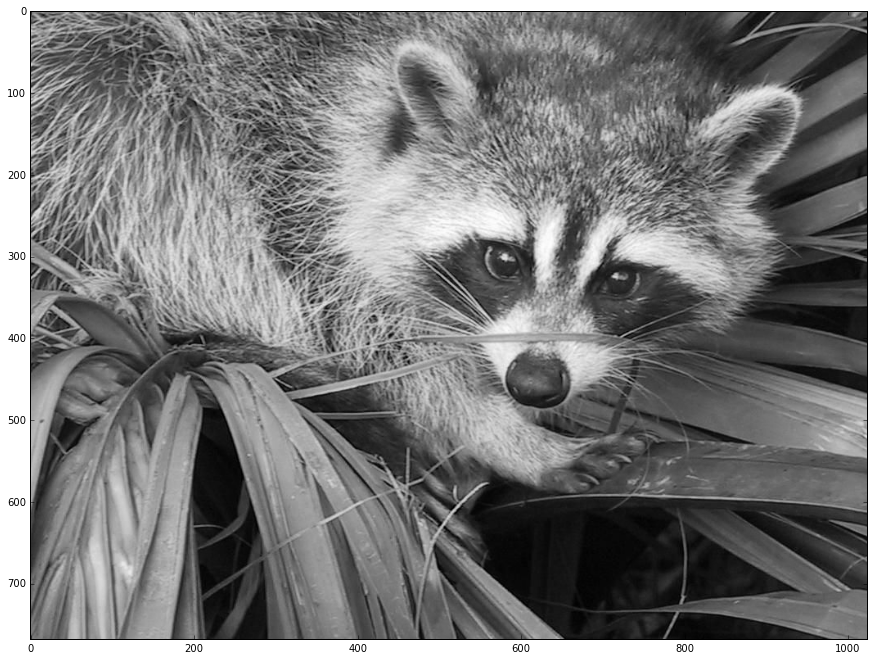

In [2]:
#Here is our dictionary learning dataset
dataset = misc.face()
dataset = np.sum(dataset.astype(np.float32),axis=2)
plt.figure(figsize=(15,15))
plt.imshow(dataset,cmap=plt.cm.gray)

In [3]:
#Helper function to loop over all dimension
def recursiveLooper( patchedImageSize, curDim, curIndex, func ):
    curIndex[curDim]=0
    for i in range(patchedImageSize[curDim]):
        if curDim > 0:
            recursiveLooper( patchedImageSize, curDim-1, curIndex, func )
        else:#last recursion step
            func( curIndex )
        curIndex[curDim]+=1
        
#Total number of patch per direction
def GetPatchedImageSize(vectorizedImage,sizePatch,shift):
    return (vectorizedImage.shape-sizePatch+shift-1)/shift
            
#divide this image into patches
def decomposeImage( vectorizedImage, sizePatch, shift ):
    dim = len(vectorizedImage.shape)
    assert(dim==len(sizePatch))
    assert(dim==len(shift))

    #shift cannot exceed actual patch size
    shift = np.minimum(shift,sizePatch)
    
    patchedImageSize = GetPatchedImageSize(vectorizedImage,sizePatch,shift)
    assert( (patchedImageSize>0).all() )
    print "patchedImageSize is "+str(patchedImageSize)
    
    #Each patch will be stored as a column in the matrix
    matrix = np.zeros((np.prod(sizePatch),np.prod(patchedImageSize)),np.float32)
    
    #define patch sampler
    def sampler(index) :
        patch = np.reshape(vectorizedImage[\
            np.meshgrid(*map(np.arange,index*shift,index*shift+sizePatch),\
            indexing='ij')],np.prod(sizePatch))
        #compute patch linearized address and update matrix
        addr = np.concatenate(([1],patchedImageSize[:-1]))
        matrix[:,np.dot(index,np.cumprod(addr))] = patch
    
    #launch actual sampling
    baseIndex = np.zeros(len(sizePatch)).astype(np.int32)                   
    recursiveLooper( patchedImageSize, dim-1, baseIndex, sampler )
    
    return matrix

In [4]:
"""
Implementing ksvd method for dictionary learning,
using OMP for sparse coding, mairal powerful implementation
    - Y: training set
    - D: the initialized dictionary
    - nb_iter: number of iterations
    - T0: sparsity constraint on the coding
"""
def ksvd(Y, D, nb_iter, T0 ):
    err = []
    for i in range(1, nb_iter+1) :
        print 'KSVD Iteration :', i,'/',nb_iter
        #Sparse coding step
        X = spams.omp(Y, D, T0)
        #Full dictionary update, atom by atom
        for k in range(0, D.shape[1]) :
            d_k, x_k, w_k = optimize_dk(k, Y, D, X)
            D[:,k] = d_k
            X[k,w_k] = x_k
        err.append(np.linalg.norm(Y-D*X)**2/Y.size)
    return(D,err)

In [5]:
"""
The function that implements the SVD part / Codebook Update Stage of the KSVD
    -k: the index of the dk column that is currently under optimization in the D dictionary
    -Y: training set
    -D: the initialized dictionary
    -X: The sparse coordinates in the Dictionary D of the training vectors columns in Y
"""
def optimize_dk(k, Y, D, X):
    #get the indices of columns whose line k is non zero
    w_k = np.nonzero(X[k,:])[1]
    #If there are training vectors containing the atom k in their decomposition
    if len(w_k) >= 1 :
        #We build the representation error matrix
        Ek = Y - D*X + np.asmatrix(D)[:,k]*X[k,:]
        Ekr = np.asarray(Ek)[:,w_k]
        U, S, Vh= np.linalg.svd(Ekr,full_matrices=False)
        #eigen vector corresponding to the largest eigval
        d_k = U[:,0]
        #The coefficient of the expression of the training vectors reconstruction error along the principal vector of SVD
        x_k = (S[0])*Vh[0,:]
    #If zero training vector uses the atom, then reinit
    else :
        restart_index = np.random.randint(Y.shape[1])
        w_k = np.array([restart_index]);
        x_k = np.array([1]);
        d_k = Y[:,restart_index];
    return(d_k, x_k, w_k)

patchedImageSize is [382 510]
KSVD Iteration : 1 / 10
KSVD Iteration : 2 / 10
KSVD Iteration : 3 / 10
KSVD Iteration : 4 / 10
KSVD Iteration : 5 / 10
KSVD Iteration : 6 / 10
KSVD Iteration : 7 / 10
KSVD Iteration : 8 / 10
KSVD Iteration : 9 / 10
KSVD Iteration : 10 / 10


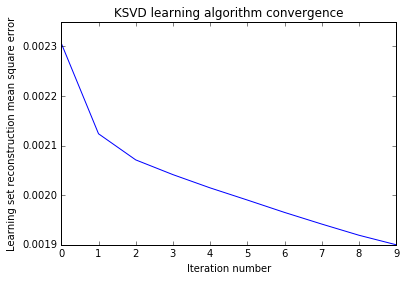

In [6]:
"""
Now use the ksvd technic on the current dataset
"""

#Extract 3D patch from 3D image, and linearize it inside a matrix as a row
sizePatch = np.array([5,5]).astype(np.int32)
shift = np.array([4,4]).astype(np.int32)
Y = decomposeImage(dataset, sizePatch, shift)

#center patches
Y -= Y.mean(axis=0)
#reduce/normalize
norm = np.linalg.norm(Y,axis=0)
idx = np.isclose(norm,0)
Y[:,~idx]/=norm[~idx]
Y = Y[:,~idx] # delete zero variance samples

#Initialize dictionary to random atoms
nbAtom = 50
Y = np.asfortranarray(Y)
D = Y[:, np.random.choice(range(Y.shape[1]),nbAtom,replace=False)]

#Perform ksvd
nbIter = 10
T0 = 5
D,err = ksvd(Y, D, nbIter, T0)

#Don't forget to add a constant patch
cstPatch = np.ones((np.prod(sizePatch),1),np.float32)
D = np.concatenate((cstPatch/np.linalg.norm(cstPatch),D),axis=1)
    
plt.figure()
plt.title("KSVD learning algorithm convergence")
plt.xlabel('Iteration number')
plt.ylabel('Learning set reconstruction mean square error')
plt.plot(range(nbIter),err)

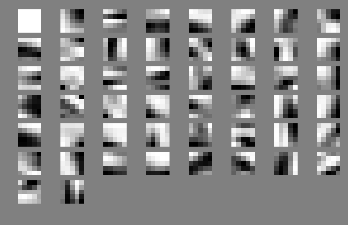

In [7]:
squareSize = np.ceil(np.sqrt(D.shape[1]))

fig = plt.figure()
for idx in range( nbAtom ):
    plt.subplot(squareSize, squareSize, idx+1 )
    plt.axis('off')
    patch = np.reshape(D[:,idx] , sizePatch)
    plt.imshow( patch, cmap='Greys',interpolation='none')
fig.patch.set_facecolor('grey')

patchedImageSize is [382 510]


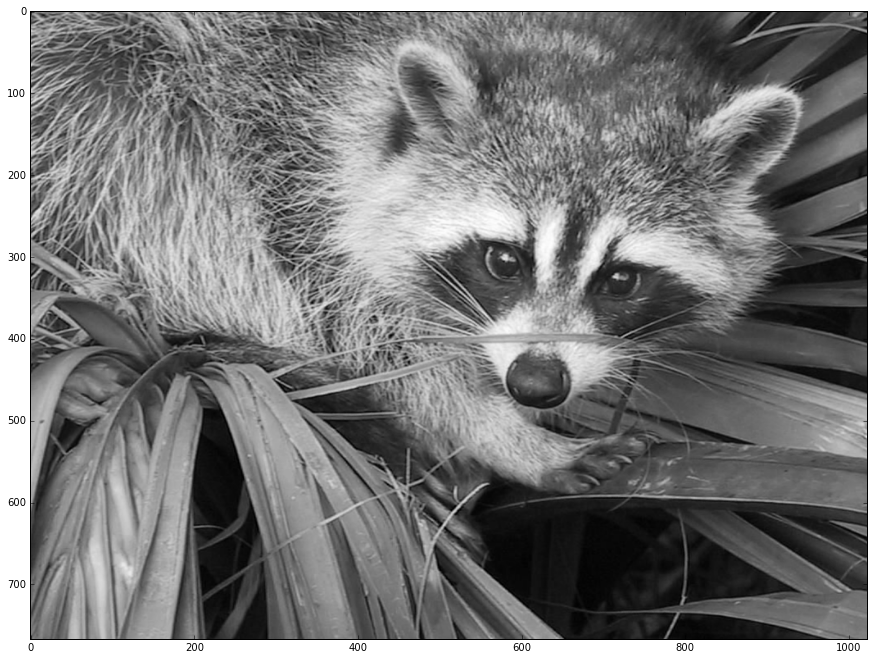

In [8]:
def reconstructImage(Y, D, T0, patchedImageSize, sizePatch, shift):
    """
    Helper function that allow to reconstruct an image
    from a dictionary, and a set of coordinates
    """
    imShape = (patchedImageSize-1)*shift+sizePatch
    dim = len(imShape)

    #Buffer for image and normalization
    Img = np.zeros(imShape, np.float32)
    Coeff = np.zeros(imShape, np.float32)
    
    #reconstruct individual patch
    method = 'OMP'
    if method=='LASSO':
        # min(α ∈ ℝp) ||x−Dα||22 + λ ||α||1 + λ2||α||22
        X = spams.lasso(Y, D, lambda1=0, lambda2=0, mode=2 )
    if method=='OMP':
        # min(α ∈ ℝp) ||x−Dα||22   s.t.   ||α||0 ≤ L using OMP
        X = spams.omp(Y, D, L=T0 )
    reco = D * X
    
    #define patch reconstructor
    def reconstructor(index) :
        #compute patch linearized address
        addr = np.concatenate(([1],patchedImageSize[:-1]))
        patch = np.reshape(reco[:,np.dot(index,np.cumprod(addr))],sizePatch)

        imgSubset = np.meshgrid(*map(np.arange,index*shift,\
            index*shift+sizePatch), indexing='ij')
        Img[imgSubset] += patch
        Coeff[imgSubset] += 1
    
    #launch actual reconstruction
    baseIndex = np.zeros(len(sizePatch)).astype(np.int32)
    recursiveLooper(patchedImageSize, dim-1, baseIndex, reconstructor)
    
    return Img/Coeff

#Perform image reconstruction
Y = np.asfortranarray(decomposeImage(dataset, sizePatch, shift))
img = reconstructImage(Y, D, T0,\
    GetPatchedImageSize(dataset,sizePatch,shift),\
    sizePatch, shift)

#img=dataset[0:img.shape[0],0:img.shape[1]]-img

plt.figure(figsize=(15,15))
plt.imshow(img, cmap=plt.cm.gray,vmin=Y.min(),vmax=Y.max())